In [ ]:
import tifffile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

def stitch_single_brain(data_dir, output_dir=None, 
                       rows=18, cols=14, 
                       rotation_k=3, flip_odd_rows=True,
                       pixel_size_um=0.875,
                       save_files=True, show_plot=False,
                       file_pattern="*.tif*"):
    """
    Reusable function to stitch a single brain slice
    
    Parameters:
    - data_dir: Path to folder with tile images
    - output_dir: Where to save results (if None, saves in data_dir)
    - rows, cols: Grid dimensions
    - rotation_k: Rotation (0=none, 1=90°, 2=180°, 3=270°)
    - flip_odd_rows: Apply serpentine correction
    - pixel_size_um: Pixel size in micrometers
    - save_files: Whether to save output files
    - show_plot: Whether to display the plot
    - file_pattern: Pattern to match image files
    
    Returns:
    - stitched_image: The stitched brain array
    - metadata: Dictionary with processing info
    """
    
    data_path = Path(data_dir)
    if output_dir is None:
        output_path = data_path
    else:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
    
    print(f"Processing: {data_path.name}")
    
    # Load image files
    image_files = sorted(data_path.glob(file_pattern))
    expected_files = rows * cols
    
    if len(image_files) != expected_files:
        print(f"⚠️  Expected {expected_files} files, found {len(image_files)}")
        if len(image_files) == 0:
            return None, {"error": "No image files found"}
    
    # Get dimensions from first image
    try:
        first_img = tifffile.imread(image_files[0])
        rotated_first = np.rot90(first_img, k=rotation_k)
        
        if len(rotated_first.shape) == 3:
            tile_h, tile_w = rotated_first.shape[:2]
            is_multichannel = True
        else:
            tile_h, tile_w = rotated_first.shape
            is_multichannel = False
            
    except Exception as e:
        print(f"❌ Error reading first image: {e}")
        return None, {"error": f"Cannot read images: {e}"}
    
    # Stitch tiles
    row_images = []
    
    for row in range(rows):
        row_tiles = []
        
        for col_in_row in range(cols):
            file_idx = row * cols + col_in_row
            
            if file_idx >= len(image_files):
                # Fill missing tiles with zeros
                tile_data = np.zeros((tile_h, tile_w), dtype=first_img.dtype)
            else:
                # Apply serpentine pattern
                if flip_odd_rows and row % 2 == 1:
                    col = cols - 1 - col_in_row
                else:
                    col = col_in_row
                
                # Load and process tile
                try:
                    img = tifffile.imread(image_files[file_idx])
                    rotated_img = np.rot90(img, k=rotation_k)
                    
                    if is_multichannel:
                        tile_data = rotated_img[:, :, 0]
                    else:
                        tile_data = rotated_img
                        
                except Exception as e:
                    print(f"⚠️  Error loading tile {file_idx}: {e}")
                    tile_data = np.zeros((tile_h, tile_w), dtype=first_img.dtype)
            
            row_tiles.append((col, tile_data))
        
        # Sort and concatenate row
        row_tiles.sort(key=lambda x: x[0])
        row_image = np.concatenate([tile[1] for tile in row_tiles], axis=1)
        row_images.append(row_image)
    
    # Concatenate all rows
    stitched = np.concatenate(row_images, axis=0)
    
    # Calculate metadata
    width_mm = stitched.shape[1] * pixel_size_um / 1000
    height_mm = stitched.shape[0] * pixel_size_um / 1000
    
    metadata = {
        "folder_name": data_path.name,
        "n_files_found": len(image_files),
        "n_files_expected": expected_files,
        "stitched_shape": stitched.shape,
        "physical_size_mm": (width_mm, height_mm),
        "pixel_size_um": pixel_size_um,
        "processing_time": datetime.now().isoformat(),
        "rotation_degrees": rotation_k * 90,
        "serpentine_correction": flip_odd_rows
    }
    
    # Save files
    if save_files:
        output_file = output_path / f"{data_path.name}_stitched.tiff"
        tifffile.imwrite(output_file, stitched)
        print(f"  Saved: {output_file.name} ({width_mm:.1f}×{height_mm:.1f} mm)")
    
    # Create plot if requested
    if show_plot:
        create_brain_plot(stitched, metadata, output_path if save_files else None)
    
    print(f"  ✅ Completed: {stitched.shape}")
    return stitched, metadata

def create_brain_plot(stitched, metadata, output_path=None):
    """
    Create and optionally save a brain slice plot
    """
    downsample = max(1, max(stitched.shape) // 2500)
    display_img = stitched[::downsample, ::downsample]
    
    # Enhance contrast
    non_zero = display_img[display_img > 0]
    if len(non_zero) > 0:
        p1, p99 = np.percentile(non_zero, [1, 99])
        display_img = np.clip(display_img.astype(np.float32), p1, p99)
        display_img = (display_img - p1) / (p99 - p1)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(display_img, cmap='gray')
    
    width_mm, height_mm = metadata['physical_size_mm']
    plt.title(f"{metadata['folder_name']}\n"
              f"{metadata['stitched_shape'][1]}×{metadata['stitched_shape'][0]} pixels "
              f"({width_mm:.1f}×{height_mm:.1f} mm)", fontsize=14)
    plt.axis('off')
    
    # Scale bar
    pixel_size_um = metadata['pixel_size_um']
    scale_pixels = int(1000 / pixel_size_um / downsample)
    if scale_pixels < 50:
        scale_pixels = int(500 / pixel_size_um / downsample)
        scale_text = "500 μm"
    else:
        scale_text = "1 mm"
    
    plt.plot([100, 100 + scale_pixels], [display_img.shape[0] - 100] * 2, 'w-', linewidth=4)
    plt.text(100, display_img.shape[0] - 130, scale_text, color='white', fontsize=12, weight='bold')
    
    if output_path:
        plot_file = Path(output_path) / f"{metadata['folder_name']}_stitched.png"
        plt.savefig(plot_file, dpi=200, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def batch_process_brains(parent_dir, output_dir=None, 
                        max_folders=None, show_progress=True,
                        save_summary=True, **stitch_kwargs):
    """
    Process multiple brain slice folders
    
    Parameters:
    - parent_dir: Directory containing brain slice folders
    - output_dir: Where to save all results
    - max_folders: Limit number of folders (for testing)
    - show_progress: Print progress updates
    - save_summary: Save processing summary CSV
    - **stitch_kwargs: Arguments passed to stitch_single_brain
    """
    
    parent_path = Path(parent_dir)
    
    if output_dir:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
    else:
        output_path = None
    
    # Find all brain slice folders
    brain_folders = [d for d in parent_path.iterdir() if d.is_dir()]
    
    if max_folders:
        brain_folders = brain_folders[:max_folders]
    
    print(f"🧠 BATCH PROCESSING {len(brain_folders)} BRAIN SLICES")
    print("=" * 60)
    
    results = []
    successful = 0
    failed = 0
    
    start_time = datetime.now()
    
    for i, folder in enumerate(brain_folders, 1):
        if show_progress:
            print(f"\n[{i}/{len(brain_folders)}] Processing: {folder.name}")
        
        try:
            # Determine output directory for this brain
            if output_path:
                brain_output = output_path / folder.name
            else:
                brain_output = folder
            
            # Process brain
            stitched, metadata = stitch_single_brain(
                folder, 
                brain_output,
                show_plot=False,  # Don't show plots in batch mode
                **stitch_kwargs
            )
            
            if stitched is not None:
                successful += 1
                metadata['status'] = 'success'
            else:
                failed += 1
                metadata['status'] = 'failed'
                
            results.append(metadata)
            
        except Exception as e:
            print(f"  ❌ Error processing {folder.name}: {e}")
            failed += 1
            results.append({
                'folder_name': folder.name,
                'status': 'error',
                'error': str(e)
            })
        
        # Progress update
        if show_progress and i % 10 == 0:
            elapsed = datetime.now() - start_time
            rate = i / elapsed.total_seconds() * 60  # folders per minute
            remaining = (len(brain_folders) - i) / rate if rate > 0 else 0
            print(f"  Progress: {i}/{len(brain_folders)} ({rate:.1f}/min, ~{remaining:.0f}min remaining)")
    
    # Final summary
    total_time = datetime.now() - start_time
    print(f"\n🎉 BATCH PROCESSING COMPLETE!")
    print(f"  Total time: {total_time}")
    print(f"  Successful: {successful}")
    print(f"  Failed: {failed}")
    print(f"  Success rate: {successful/(successful+failed)*100:.1f}%")
    
    # Save summary
    if save_summary and results:
        summary_df = pd.DataFrame(results)
        summary_file = (output_path or parent_path) / "stitching_summary.csv"
        summary_df.to_csv(summary_file, index=False)
        print(f"  Summary saved: {summary_file}")
        
        # Show failed cases
        failed_cases = summary_df[summary_df['status'] != 'success']
        if len(failed_cases) > 0:
            print(f"\n⚠️  {len(failed_cases)} failed cases:")
            for _, case in failed_cases.iterrows():
                print(f"    {case['folder_name']}: {case.get('error', 'Unknown error')}")
    
    return results

# Example usage:

# 1. Process a single brain (test first)
single_result = stitch_single_brain(
    data_dir='/Users/dennis.jungchildmind.org/Downloads/b6c20ca5-d8e1-43e4-b8b8-f981eb0df2b7-0150',
    show_plot=True
)

# 2. Process first 5 folders (test batch)
# test_results = batch_process_brains(
#     parent_dir='/path/to/parent/folder/with/300/brain/folders',
#     output_dir='/path/to/output/directory',
#     max_folders=5,  # Test with 5 first
#     save_files=True,
#     show_progress=True
# )

# 3. Process all 300 folders
# all_results = batch_process_brains(
#     parent_dir='/path/to/parent/folder/with/300/brain/folders',
#     output_dir='/path/to/output/directory',
#     save_files=True,
#     show_progress=True,
#     # You can override any stitch parameters:
#     rows=18, cols=14, rotation_k=3, flip_odd_rows=True
# )


Processing: b6c20ca5-d8e1-43e4-b8b8-f981eb0df2b7-0150
⚠️  Expected 252 files, found 253
  Saved: b6c20ca5-d8e1-43e4-b8b8-f981eb0df2b7-0150_stitched.tiff (10.2×13.1 mm)
  ✅ Completed: (14976, 11648)


🧠 Processing single brain slice...
Processing: b6c20ca5-d8e1-43e4-b8b8-f981eb0df2b7-0150
⚠️  Expected 252 files, found 253
  Saved: b6c20ca5-d8e1-43e4-b8b8-f981eb0df2b7-0150_stitched.tiff (10.2×13.1 mm)
  ✅ Completed: (14976, 11648)

🎉 Done! Your brain slice is ready!
Shape: (14976, 11648)
Physical size: 10.2 × 13.1 mm


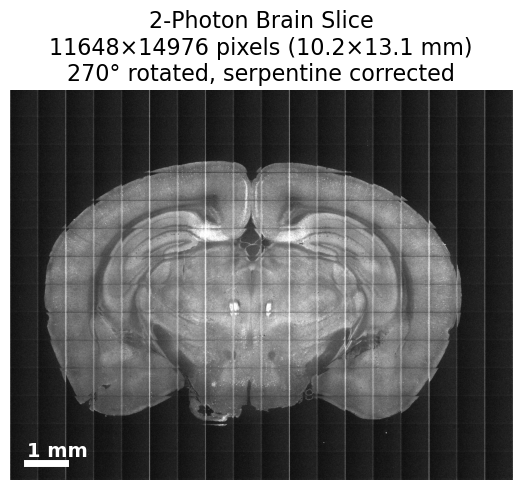

Files: brain_slice_final.tiff, brain_slice_final.png


<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_single_result(stitched, metadata, show_plot=True, save_plot=False, output_path=None):
    """
    Plot a single stitched brain result with the same style as before
    """
    if stitched is None:
        print("No stitched image to plot")
        return
    
    # Create display version
    downsample = max(1, max(stitched.shape) // 2500)
    display_img = stitched[::downsample, ::downsample]
    
    # Rotate the display image 270° like in your original code
    display_img = np.rot90(display_img, k=3)  # 270° counter-clockwise rotation
    
    # Enhance contrast
    non_zero = display_img[display_img > 0]
    if len(non_zero) > 0:
        p1, p99 = np.percentile(non_zero, [1, 99])
        display_img = np.clip(display_img.astype(np.float32), p1, p99)
        display_img = (display_img - p1) / (p99 - p1)
    
    # Create plot with same style as your original
    plt.figure(figsize=(10, 5))
    plt.imshow(display_img, cmap='gray')
    
    # Get metadata
    width_mm, height_mm = metadata['physical_size_mm']
    original_shape = metadata['stitched_shape']
    
    plt.title(f'2-Photon Brain Slice\n{original_shape[1]}×{original_shape[0]} pixels '
              f'({width_mm:.1f}×{height_mm:.1f} mm)\n270° rotated, serpentine corrected', fontsize=16)
    plt.axis('off')
    
    # Scale bar
    pixel_size_um = metadata['pixel_size_um']
    scale_pixels = int(1000 / pixel_size_um / downsample)  # 1mm
    if scale_pixels < 50:
        scale_pixels = int(500 / pixel_size_um / downsample)  # 500μm
        scale_text = "500 μm"
    else:
        scale_text = "1 mm"
    
    plt.plot([100, 100 + scale_pixels], [display_img.shape[0] - 100] * 2, 'w-', linewidth=5)
    plt.text(100, display_img.shape[0] - 140, scale_text, color='white', fontsize=14, weight='bold')
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    if save_plot and output_path:
        plot_file = Path(output_path) / f"{metadata['folder_name']}_brain_slice_final.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {plot_file}")
    
    return plt.gcf()

# Process your single brain and plot it
data_directory = '/Users/dennis.jungchildmind.org/Downloads/b6c20ca5-d8e1-43e4-b8b8-f981eb0df2b7-0150'

print("🧠 Processing single brain slice...")
stitched_brain, brain_metadata = stitch_single_brain(
    data_dir=data_directory,
    save_files=True,
    show_plot=False  # We'll plot separately
)

if stitched_brain is not None:
    print(f"\n🎉 Done! Your brain slice is ready!")
    print(f"Shape: {stitched_brain.shape}")
    print(f"Physical size: {brain_metadata['physical_size_mm'][0]:.1f} × {brain_metadata['physical_size_mm'][1]:.1f} mm")
    
    # Plot with the same style as your original code
    plot_single_result(stitched_brain, brain_metadata, show_plot=True, save_plot=True)
    
    # Also print the same success message as before
    print(f"Files: brain_slice_final.tiff, brain_slice_final.png")
else:
    print("❌ Failed to process brain slice")